In [1]:
import pandas as pd 
import numpy as np
import datetime
from pathlib import Path
import os

pd.set_option('display.max_columns', 500)


In [2]:
data_path = Path(os.getcwd()) / 'data'

In [3]:
data_path

WindowsPath('C:/Users/hwojewoda/OneDrive - KPMG/Desktop/wec_2022/data')

In [4]:
def read_all_csv(data_path, data_type='train'):
    bkg_drop_cols = ['UPGRADED_FLAG', 'UPGRADE_TYPE', 'UPGRADE_SALES_DATE']
    bkg = pd.read_csv(data_path / f'BKG_{data_type}.csv', sep=';').drop(columns=bkg_drop_cols)
    tkt = pd.read_csv(data_path / f'TKT_{data_type}.csv', sep=';')
    fcp = pd.read_csv(data_path / f'FCP_{data_type}.csv', sep=';')
    df = fcp.merge(tkt, on='TICKET_NUMBER', how='left')
    df = df.merge(bkg, on='BOOKING_ID', how='left')
    return df 

In [5]:
df = read_all_csv(data_path=data_path)

In [6]:
# emd = pd.read_csv(data_path / 'EMD_train.csv', sep=';')

In [7]:
# df = df.merge(emd, how='left', left_on='TICKET_NUMBER', right_on='REFERENCE_TICKET_NUMBER')
# df.shape

In [8]:
# sus_air_type = (df[df['UPGRADED_FLAG'] == 'Y']['AIRCRAFT_TYPE'].value_counts() / df['AIRCRAFT_TYPE'].value_counts()).sort_values(ascending=False).head(5).index.tolist()

In [9]:
sus_air_type = ['763', '788', '789', '332', '787']

In [10]:
# sus_currency = (df[df['UPGRADED_FLAG'] == 1]['CURRENCY'].value_counts() / df['CURRENCY'].value_counts()).sort_values(ascending=False).head(6).index.tolist()

In [11]:
sus_currency = ['JPY', 'USD', 'CAD', 'SGD', 'VND', 'AED']

# Co zmieniamy 
1. 

In [13]:
def clean_df(data, data_type='train'):
    drop_cols = [
        "TICKET_NUMBER",
        "UPGRADE_SALES_DATE",
        "ORIGIN_AIRPORT_CODE",
        "DESTINATION_AIRPORT_CODE",
        "SALES_DATE",
        "FLIGHT_DATE_LOCAL",
        "MARKETING_CARRIER",
        "OPERATIONAL_CARRIER",
        "BOOKED_CLASS",
        "AIRCRAFT_TYPE",
        "FARE_BASIS",
        "UPGRADE_TYPE",
        "UPGRADE_SALES_DATE",
        "BOOKING_ID",
        "ORIGINAL_TICKET_NUMBER",
        "SEGMENTS",
        "FLIGHT_COUPONS",
        "FORM_OF_PAYMENT",
        "CURRENCY",
        "TOTAL_PRICE",
        "LOYAL_CUSTOMER_ID",
        "LOYAL_CUSTOMER_DATE_OF_BIRTH",
        "LOYAL_CUSTOMER_REGISTERED_DATE",
        "SALES_DATE",
        "SALES_MARKET",
        "SEGMENTS",
        "INTINERARY",
        "BOOKING_ORIGIN_AIRPORT",
        "BOOKING_ORIGIN_COUNTRY_CODE",
        "BOOKING_DEPARTURE_TIME_UTC",
        "BOOKING_DESTINATION_AIRPORT",
        "BOOKING_DESTINATION_COUNTRY_CODE",
        "BOOKING_ARRIVAL_TIME_UTC",
    ]
    
    sus_air_type = ["763", "788", "789", "332", "787"]
    sus_currency = ["JPY", "USD", "CAD", "SGD", "VND", "AED"]
    sus_payment = [
        "UNION",
        "CCDS6",
        "CCSW9",
        "NET R",
        "CCJC3",
        "CCAX3",
        "BARTE",
        "CCVI4",
        "PAY24",
    ]
    df = data.copy()
    df["FLIGHT_DATE_LOCAL"] = pd.to_datetime(df["FLIGHT_DATE_LOCAL"])
    df["SALES_DATE"] = pd.to_datetime(df["SALES_DATE"])
    df["sale_to_flight_time"] = df["FLIGHT_DATE_LOCAL"] - df["SALES_DATE"]
    df["sale_to_flight_time"] = df["sale_to_flight_time"].apply(lambda x: x.days)

    stay_lenght_map = {-9999: None}
    df["STAY_LENGTH_D"] = df["STAY_LENGTH_D"].replace(stay_lenght_map)
    df["BOOKING_ARRIVAL_TIME_UTC"] = pd.to_datetime(df["BOOKING_ARRIVAL_TIME_UTC"])
    df["BOOKING_DEPARTURE_TIME_UTC"] = pd.to_datetime(df["BOOKING_DEPARTURE_TIME_UTC"])

    df["flight_len"] = df["BOOKING_ARRIVAL_TIME_UTC"] - df["BOOKING_DEPARTURE_TIME_UTC"]
    df["flight_len"] = df["flight_len"].apply(lambda x: x.seconds / 3600)

    df["TIME_DEPARTURE_LOCAL_TIME"] = pd.to_datetime(df["TIME_DEPARTURE_LOCAL_TIME"])
    df["TIME_DEPARTURE_LOCAL_TIME"] = df["TIME_DEPARTURE_LOCAL_TIME"].apply(
        lambda x: x.hour
    )

    def get_if_add_upgrade(df):
        emd = pd.read_csv(data_path / "EMD_train.csv", sep=";")
        return np.where(
            np.isin(df["TICKET_NUMBER"], emd["REFERENCE_TICKET_NUMBER"].unique()), 1, 0
        )

    df["if_additional_upgrade"] = get_if_add_upgrade(df)
    df["same_carrier"] = np.where(
        df["MARKETING_CARRIER"] == df["OPERATIONAL_CARRIER"], 1, 0
    )
    df["is_sus_aircraft"] = np.where(np.isin(df["AIRCRAFT_TYPE"], sus_air_type), 1, 0)

    if data_type == 'train': 
        df["UPGRADED_FLAG"] = df["UPGRADED_FLAG"].map({"Y": 1, "N": 0})

    df["is_sus_payment"] = np.where(np.isin(df["FORM_OF_PAYMENT"], sus_payment), 1, 0)
    df["intinerary_len"] = df["INTINERARY"].apply(lambda x: len(x.split("-")))
    df["is_sus_currency"] = np.where(np.isin(df["FORM_OF_PAYMENT"], sus_currency), 1, 0)

    df["PAX_GENDER"] = df["PAX_GENDER"].map({"M": 1, "F": 0})

    df["CORPORATE_CONTRACT_FLG"] = df["CORPORATE_CONTRACT_FLG"].map({"Y": 1, "N": 0})
    df["LOYAL_CUSTOMER"] = df["LOYAL_CUSTOMER"].map({"Y": 1, "N": 0})

    df["BOOKING_LONG_HOUL_FLAG"] = df["BOOKING_LONG_HOUL_FLAG"].map({"Y": 1, "N": 0})
    df["BOOKING_DOMESTIC_FLAG"] = df["BOOKING_DOMESTIC_FLAG"].map({"Y": 1, "N": 0})

    return df.drop(columns=drop_cols)

In [14]:
# sus_payment = (df[df['UPGRADED_FLAG'] == 1]['FORM_OF_PAYMENT'].value_counts() / df['FORM_OF_PAYMENT'].value_counts()).sort_values(ascending=False).head(9).index.tolist()

In [15]:
final_df = clean_df(df)

AttributeError: 'float' object has no attribute 'astype'

In [16]:
def oh_encoding(data): 
    df = data.copy()
    oh_cols = [
        "FLIGHT_RANGE",
        "BOOKED_CABIN",
        "VAB",
        "PAX_TYPE",
        "SALES_CHANNEL",
        "TRIP_TYPE",
    ]
    oh_df = pd.get_dummies(data[oh_cols], prefix=oh_cols, drop_first=True)
    return pd.concat([df, oh_df], axis=1).drop(oh_cols, axis=1)

In [17]:
final_df = oh_encoding(final_df)

In [18]:
final_df 

,COUPON_NUMBER,TIME_DEPARTURE_LOCAL_TIME,FLIGHT_DISTANCE,UPGRADED_FLAG,TOTAL_PRICE_PLN,PAX_GENDER,CORPORATE_CONTRACT_FLG,LOYAL_CUSTOMER,BOOKING_WINDOW_D,STAY_LENGTH_D,BOOKING_LONG_HOUL_FLAG,BOOKING_DOMESTIC_FLAG,PAX_N,sale_to_flight_time,flight_len,if_additional_upgrade,same_carrier,is_sus_aircraft,is_sus_payment,intinerary_len,is_sus_currency,FLIGHT_RANGE_LONG-HAUL,FLIGHT_RANGE_SHORT-HAUL,FLIGHT_RANGE_UNKNOWN,BOOKED_CABIN_Economy,BOOKED_CABIN_Premium,VAB_FLEX,VAB_FULL-FLEX,VAB_OTHER,VAB_SAVER,VAB_SEMI-FLEX,VAB_STANDARD,PAX_TYPE_CHILD,PAX_TYPE_INFANT,SALES_CHANNEL_ATO_CTO,SALES_CHANNEL_CALL CENTER,SALES_CHANNEL_DCS,SALES_CHANNEL_LOT TRAVEL,SALES_CHANNEL_LOT.COM,TRIP_TYPE_ONE WAY,TRIP_TYPE_ROUND TRIP
0,2,19.0,1344,0,620.35,1,0,0,121.0,4.0,0,0,1,125,14.500000,0,1,0,0,3,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
1,1,13.0,6942,0,2151.49,1,0,0,228.0,21.0,1,0,4,228,22.750000,0,1,1,0,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,16.0,7521,0,2270.18,0,0,0,55.0,15.0,1,0,1,69,22.250000,1,1,1,1,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,1,6.0,721,0,1096.16,0,0,0,12.0,7.0,0,0,1,12,11.166667,0,1,0,0,5,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,2,18.0,522,0,752.15,1,0,0,6.0,1.0,0,0,1,7,23.500000,0,1,0,0,3,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9224582,1,19.0,523,0,813.64,1,0,0,0.0,None,0,0,1,0,4.666667,0,1,0,0,3,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
9224583,2,17.0,1070,0,675.51,1,0,0,116.0,8.0,0,0,3,124,8.000000,0,1,0,0,3,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
9224584,1,7.0,753,0,1408.80,1,0,0,36.0,None,0,0,1,36,5.833333,0,1,0,0,3,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9224585,1,18.0,940,0,1157.97,1,0,0,37.0,3.0,0,0,3,37,7.416667,1,1,0,0,3,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [19]:
stay_lenght_map = {None: 0}
final_df["STAY_LENGTH_D"] = final_df["STAY_LENGTH_D"].replace(stay_lenght_map)

In [20]:
final_df = final_df.dropna()

In [21]:
X = final_df.drop(['UPGRADED_FLAG'], axis = 'columns')
y = final_df['UPGRADED_FLAG']
X

,COUPON_NUMBER,TIME_DEPARTURE_LOCAL_TIME,FLIGHT_DISTANCE,TOTAL_PRICE_PLN,PAX_GENDER,CORPORATE_CONTRACT_FLG,LOYAL_CUSTOMER,BOOKING_WINDOW_D,STAY_LENGTH_D,BOOKING_LONG_HOUL_FLAG,BOOKING_DOMESTIC_FLAG,PAX_N,sale_to_flight_time,flight_len,if_additional_upgrade,same_carrier,is_sus_aircraft,is_sus_payment,intinerary_len,is_sus_currency,FLIGHT_RANGE_LONG-HAUL,FLIGHT_RANGE_SHORT-HAUL,FLIGHT_RANGE_UNKNOWN,BOOKED_CABIN_Economy,BOOKED_CABIN_Premium,VAB_FLEX,VAB_FULL-FLEX,VAB_OTHER,VAB_SAVER,VAB_SEMI-FLEX,VAB_STANDARD,PAX_TYPE_CHILD,PAX_TYPE_INFANT,SALES_CHANNEL_ATO_CTO,SALES_CHANNEL_CALL CENTER,SALES_CHANNEL_DCS,SALES_CHANNEL_LOT TRAVEL,SALES_CHANNEL_LOT.COM,TRIP_TYPE_ONE WAY,TRIP_TYPE_ROUND TRIP
0,2,19.0,1344,620.35,1,0,0,121.0,4.0,0,0,1,125,14.500000,0,1,0,0,3,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
1,1,13.0,6942,2151.49,1,0,0,228.0,21.0,1,0,4,228,22.750000,0,1,1,0,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,16.0,7521,2270.18,0,0,0,55.0,15.0,1,0,1,69,22.250000,1,1,1,1,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,1,6.0,721,1096.16,0,0,0,12.0,7.0,0,0,1,12,11.166667,0,1,0,0,5,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,2,18.0,522,752.15,1,0,0,6.0,1.0,0,0,1,7,23.500000,0,1,0,0,3,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9224579,1,22.0,6863,4619.66,0,0,0,81.0,23.0,1,0,4,80,22.083333,0,1,1,0,3,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
9224580,1,16.0,1102,759.47,0,0,0,97.0,3.0,0,0,3,97,4.916667,0,1,0,0,3,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
9224581,3,14.0,819,501.76,1,0,0,76.0,47.0,1,0,3,122,15.250000,0,1,0,1,5,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
9224583,2,17.0,1070,675.51,1,0,0,116.0,8.0,0,0,3,124,8.000000,0,1,0,0,3,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
X_train

,COUPON_NUMBER,TIME_DEPARTURE_LOCAL_TIME,FLIGHT_DISTANCE,TOTAL_PRICE_PLN,PAX_GENDER,CORPORATE_CONTRACT_FLG,LOYAL_CUSTOMER,BOOKING_WINDOW_D,STAY_LENGTH_D,BOOKING_LONG_HOUL_FLAG,BOOKING_DOMESTIC_FLAG,PAX_N,sale_to_flight_time,flight_len,if_additional_upgrade,same_carrier,is_sus_aircraft,is_sus_payment,intinerary_len,is_sus_currency,FLIGHT_RANGE_LONG-HAUL,FLIGHT_RANGE_SHORT-HAUL,FLIGHT_RANGE_UNKNOWN,BOOKED_CABIN_Economy,BOOKED_CABIN_Premium,VAB_FLEX,VAB_FULL-FLEX,VAB_OTHER,VAB_SAVER,VAB_SEMI-FLEX,VAB_STANDARD,PAX_TYPE_CHILD,PAX_TYPE_INFANT,SALES_CHANNEL_ATO_CTO,SALES_CHANNEL_CALL CENTER,SALES_CHANNEL_DCS,SALES_CHANNEL_LOT TRAVEL,SALES_CHANNEL_LOT.COM,TRIP_TYPE_ONE WAY,TRIP_TYPE_ROUND TRIP
651282,2,8.0,2111,683.65,1,0,0,138.0,10.0,0,0,3,148,19.333333,0,1,0,0,3,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5371011,2,16.0,1156,1935.25,1,0,0,8.0,1.0,0,0,1,8,8.833333,0,1,0,1,5,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4170873,2,13.0,1156,1952.83,1,0,1,6.0,1.0,0,0,1,6,12.500000,0,0,0,0,5,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
7663736,1,10.0,2287,1098.74,0,0,0,2.0,9.0,0,0,80,2,8.333333,0,1,0,0,3,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5739048,1,5.0,277,807.73,0,0,0,27.0,3.0,0,0,1,27,13.416667,0,1,0,0,5,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4725719,2,14.0,246,1178.58,1,0,0,0.0,5.0,0,0,1,1,18.666667,0,1,0,0,5,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6376574,2,16.0,6873,2158.45,1,0,0,66.0,14.0,1,0,1,66,2.833333,0,1,0,0,6,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1983316,1,19.0,1077,1373.40,0,0,0,23.0,11.0,0,0,1,23,15.000000,0,1,0,0,3,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
1784080,1,9.0,523,828.57,1,1,0,55.0,3.0,0,0,1,55,9.916667,0,1,0,1,3,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [23]:
y.value_counts()

0    7420027
1       7725
Name: UPGRADED_FLAG, dtype: int64

In [24]:
9215782/8805

1046.6532651902328

In [25]:
import xgboost as xgb

In [28]:
xgb_model = xgb.XGBClassifier(scale_pos_weight = 1046.6532651902328, seed=42, use_label_encoder=False)
xgb_model.fit(X_train, y_train, eval_metric='aucpr')

RandomForestClassifier(class_weight='balanced')

In [29]:
import matplotlib.pyplot as plt
import seaborn as sn

In [30]:
def heatmap(model, y_test, X_test):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, model.predict(X_test))

    %matplotlib inline
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(7,5))
    sn.heatmap(cm, annot=True, fmt='d')
    plt.xlabel("Predicted")
    plt.ylabel("Truth")

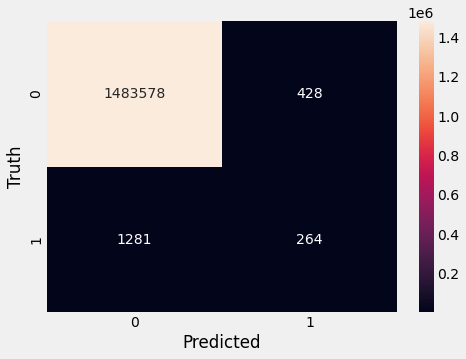

In [31]:
heatmap(xgb_model, y_test, X_test)

Best Threshold=0.009658


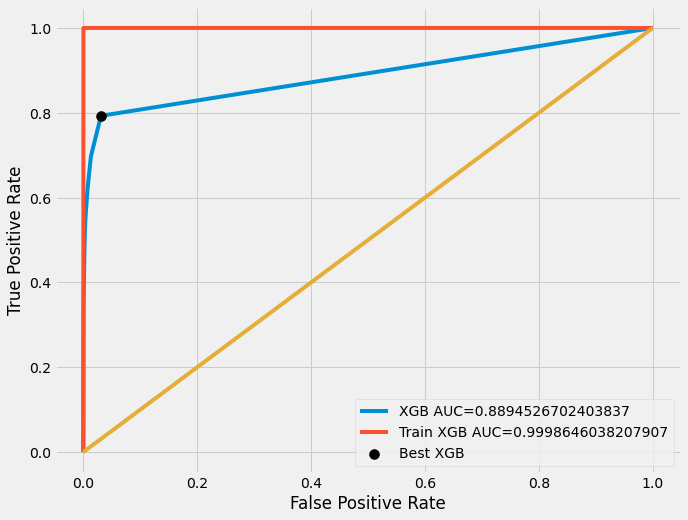

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
y_pred_proba = xgb_model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

y_pred_proba2 = xgb_model.predict_proba(X_train)[::,1]
fpr2, tpr2, thresholds2 = roc_curve(y_train,  y_pred_proba2)
auc2 = roc_auc_score(y_train, y_pred_proba2)

# ROC
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label="XGB AUC="+str(auc))
plt.plot(fpr2, tpr2, label="Train XGB AUC="+str(auc2))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best XGB', s=100, zorder=3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.plot((0, 1), (0, 1))
plt.show()

In [45]:
preds = xgb_model.predict_proba(X_test["FLIGHT_DISTANCE"])[::,1]

In [51]:
preds.astype(str)

array(['0.035022665', '0.004740428', '0.8892158', ..., '0.024203291',
       '0.08101245', '0.03888788'], dtype='<U32')

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore')
xgb_model = xgb.XGBClassifier(scale_pos_weight = 1046.6532651902328, seed=42, use_label_encoder=False)
kfold = StratifiedKFold(n_splits=5)
results = cross_val_score(xgb_model, X["FLIGHT_DISTANCE"], y, cv=kfold, scoring='roc_auc', fit_params={'eval_metric':'aucpr'})
print("średnia:", results.mean())
print('auc score:', results)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore')
lista_kolumn = ['FLIGHT_DISTANCE']
wszystkie_kolumny = X.columns.tolist()
x=0
while x<len(wszystkie_kolumny):
    if len(results) != 1 and results.mean() > prev_result:
        prev_result = results.mean()
    while wszystkie_kolumny[x] in lista_kolumn:
        x += 1
    else:
        lista_kolumn.append(wszystkie_kolumny[x])
    kolumny = X[lista_kolumn]
    xgb_model = xgb.XGBClassifier(**best_hypers, scale_pos_weight = 1046.6532651902328, seed=42, use_label_encoder=False)
    kfold = StratifiedKFold(n_splits=5)
    results = cross_val_score(xgb_model, kolumny, y, cv=kfold, scoring='roc_auc', fit_params={'eval_metric':'aucpr'})
    print("średnia:", results.mean())
    print('auc score:', results)
    print('kolumny:', kolumny.columns)
    if prev_result > results.mean():
        lista_kolumn.remove(wszystkie_kolumny[x])
    x += 1